## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
from catboost import CatBoostClassifier

import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [4]:
data = pd.read_csv(
    'data/customer_segmentation_project.csv',
    encoding="ISO-8859-1",
    dtype={'CustomerID': str,'InvoiceID': str}
    )
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Признаки 'Quantity' и 'UnitPrice' числовые, остальные признаки имеют тип object.
В признаках 'Description' и 'CustomerID' содержатся пропущенные значения.

Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуем столбец InvoiceDate в формат datetime.


In [21]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceDate'].describe()

count                  391150
unique                  17166
top       2011-11-14 15:27:00
freq                      541
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

Посмотрим на основные описательные статистики

In [7]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


В столбцах 'Quantity' (количество товаров), 'UnitPrice' (цена за единицу) содержатся отрицательные значения, что возможно является выбросом и требует дополнительного анализа. Посмотрим описательные статистики без учета отрицательных значений в данных признаках.

In [9]:
data[(data['UnitPrice'] >= 0) & (data['Quantity'] >=0)].describe()

,Quantity,UnitPrice
count,531283.000000,531283.000000
mean,10.655299,3.898954
std,156.830617,35.876279
min,1.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


Кроме отрицательных значений присутствует также нулевое значение стоимости товара, что также, кажется, некорректным.

Посмотрим описательные статистики для нечисловых признаков.

In [13]:
data.describe(include='object')

,InvoiceNo,StockCode,Description,CustomerID,Country
count,541909,541909,540455,406829,541909
unique,25900,4070,4223,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,1114,2313,2369,7983,495478


## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


Начнем с пропусков. 

Так как мы решаем задачу сегментации клиентов, то строки с пропусками в 'CustomerID' можно смело удалить.

In [17]:
data.dropna(subset='CustomerID', inplace=True)
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

После удаления пропусков в 'CustomerID', пропущенных значений в данных не осталось.

Проверим наличие дубликатов и удалим при необходимости.

In [20]:
data.duplicated().sum()

5225

In [21]:
data.drop_duplicates(inplace=True)
data.shape

(401604, 8)

Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [22]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Как было сказано в описании датасета, символ "C" перед номером заказа указывает на возврат. Можно предположить, что отрицательное значение 'Quantity' также означает возврат товара.
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями.

Посмотрим, сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата.

In [25]:
negative_quantity['InvoiceNo'].apply(lambda x: 1 if x[0] != 'C' else 0).sum()

0

Действительно, все транзакции с отрицательным количеством содержат признак возврата в 'InvoiceNo'.
Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:

In [26]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

In [27]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(
    lambda x: 1 if x[0] == 'C' else 0
)
nb_products_per_basket['order_canceled'].value_counts(normalize = True)

0    0.835331
1    0.164669
Name: order_canceled, dtype: float64

Более 16% заказов являются возвратами.

Давайте поближе взглянем на отмененные заказы:


In [28]:
nb_products_per_basket[nb_products_per_basket['order_canceled'] == 1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [29]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Мы нашли пример пары «заказ-возврат». Значения всех признаков, кроме 'InvoiceNo', 'InvoiceDate' и 'Quantity' у этой пары совпадает, при этом 'Quantity' для возврата равно 'Quantity' для заказа, только с минусом.

Проверим гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

In [45]:
for i in negative_quantity.index:
    temp_data = data[(data['CustomerID'] == negative_quantity.loc[i,'CustomerID']) &
                     (data['StockCode'] == negative_quantity.loc[i,'StockCode']) &
                     (data['Quantity'] == -negative_quantity.loc[i,'Quantity']) &
                     (data['InvoiceNo'] != negative_quantity.loc[i,'InvoiceNo'])
         ]
    if temp_data.shape[0] == 0:
        display(negative_quantity.loc[i])
        break

InvoiceNo                  C536379
StockCode                        D
Description               Discount
Quantity                        -1
InvoiceDate    2010-12-01 09:41:00
UnitPrice                     27.5
CustomerID                   14527
Country             United Kingdom
Name: 141, dtype: object

Мы нашли пример, который опровергает нашу гипотезу.

Посмотрим на клиента с идентификатором 14527:

In [46]:
data[data['CustomerID'] == '14527'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров нет. Вероятно, причина кроется в типе товара: данный товар обозначен как D (StockCode) - Discount.

Проверим новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если товар не имеет тип D - Discount.

In [47]:
for i in negative_quantity.index:
    temp_data = data[(data['CustomerID'] == negative_quantity.loc[i,'CustomerID']) &
                     (data['StockCode'] == negative_quantity.loc[i,'StockCode']) &
                     (data['Quantity'] == -negative_quantity.loc[i,'Quantity']) &
                     (data['InvoiceNo'] != negative_quantity.loc[i,'InvoiceNo'])]
    if temp_data.shape[0] == 0 and negative_quantity.loc[i,'StockCode'] != 'D':
        display(negative_quantity.loc[i])
        break

InvoiceNo                              C536383
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
InvoiceDate                2010-12-01 09:49:00
UnitPrice                                 4.65
CustomerID                               15311
Country                         United Kingdom
Name: 154, dtype: object

Новая гипотеза также не подтвердилась.

Посмотрим на транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [48]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Вероятно, заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара).

При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).

In [49]:
# функция get_quantity_canceled() принимает на вход таблицу с транзакциями
# и возвращает объект Series — столбец, в котором указано количество 
# возвращённого впоследствии товара для каждой транзакции
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
quantity_canceled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
541904    0.0
541905    0.0
541906    0.0
541907    0.0
541908    0.0
Length: 401604, dtype: float64

In [50]:
data['QuantityCanceled'] = quantity_canceled

Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара.  

In [54]:
data.drop(negative_quantity.index, axis=0, inplace=True)
data.shape

(392732, 9)

Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


С помощью регулярных выражений найдем такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

In [58]:
data['StockCode'][data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)].value_counts()

POST            1099
M                285
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: StockCode, dtype: int64

Нашли 6 таких кодов, которые судя по названию говорят о доставке, банковских комиссиях и др. Удалим их из нашего датасета.

In [70]:
data_spec_codes = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]
data.drop(data_spec_codes.index, axis=0, inplace=True)
data.shape

(391183, 9)

Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

In [76]:
data[data['UnitPrice'] == 0].shape[0]

33

Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалим их.


In [77]:
data.drop(data[data['UnitPrice'] == 0].index, inplace=True)
data.shape

(391150, 9)

Этап очистки данных завершён. Сохраним полученный результат в отдельный файл.

In [ ]:
data.to_csv('data/data_cleaning.csv',index=False)

## 4. Разведывательный анализ данных

Проведем разведывательный анализ и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


In [5]:
#data = pd.read_csv('data/data_cleaning.csv')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


Выясним, в каких странах живут клиенты.

Построим график, отражающий количество клиентов в каждой из стран.

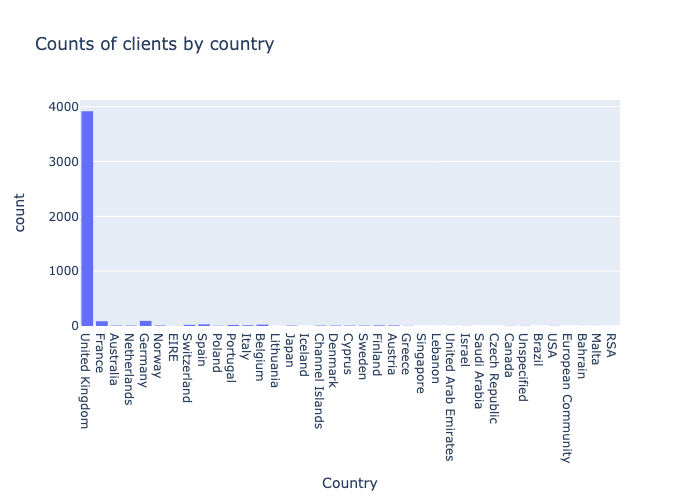

In [11]:
fig = px.histogram(
    data[['CustomerID','Country']].drop_duplicates(), 
    x='Country',
    barmode='group',
    title='Counts of clients by country',
    
)
fig.show('png')

Подавляющее большинство клиентов проживает в Великобритании.

Посмотрим распределение заказов в разрезе стран. Для этого построим визуализацию количества поступающих заказов в разрезе стран.

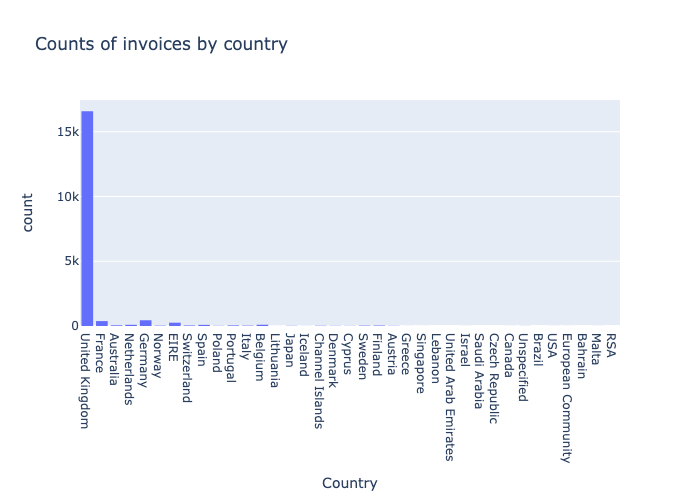

In [16]:
fig = px.histogram(
    data[['InvoiceNo','Country']].drop_duplicates(), 
    x='Country',
    barmode='group',
    title='Counts of invoices by country',
    
)
fig.show('png')

Ситуация по заказам аналогична, что вполне логично: по количеству заказов также лидирует Великобритания с большим отрывом.

Добавим в датасет общую цену заказа (TotalPrice).
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**


In [15]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
data['TotalPrice'].describe()

count    391150.000000
mean         21.126404
std          67.823746
min         -81.000000
25%           4.680000
50%          11.700000
75%          19.500000
max        7144.720000
Name: TotalPrice, dtype: float64

Посмотрим на страны, клиенты из которых приносят компании больше всего выручки.

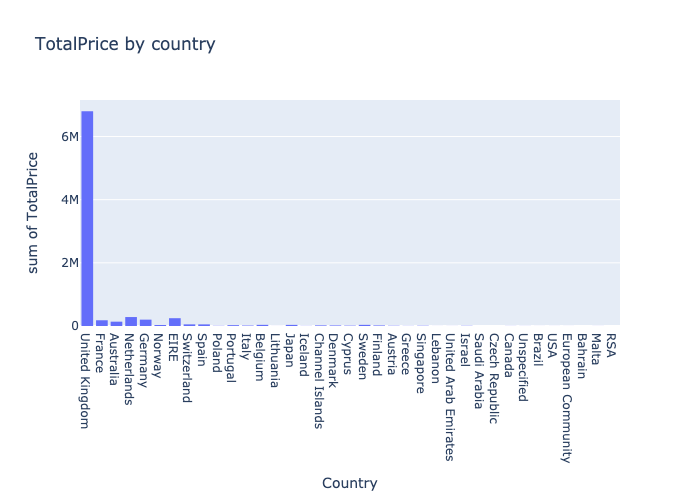

In [19]:
fig = px.histogram(
    data, 
    x='Country',
    y='TotalPrice',
    barmode='group',
    title='TotalPrice by country'    
)
fig.show('png')

Интересно, что Нидерланды находятся на шестом месте по количеству заказов, однако, по выручке Нидерланды находятся на втором месте.

Теперь займёмся временными характеристиками.


Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

In [30]:
data['Month'] = data['InvoiceDate'].dt.month
data['DayOfWeek'] = data['InvoiceDate'].dt.weekday
data['Hour'] = data['InvoiceDate'].dt.hour
data['Date'] = data['InvoiceDate'].dt.date
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,Month,DayOfWeek,Hour,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30,12,2,8,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,2,8,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00,12,2,8,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,2,8,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,2,8,2010-12-01


Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам.

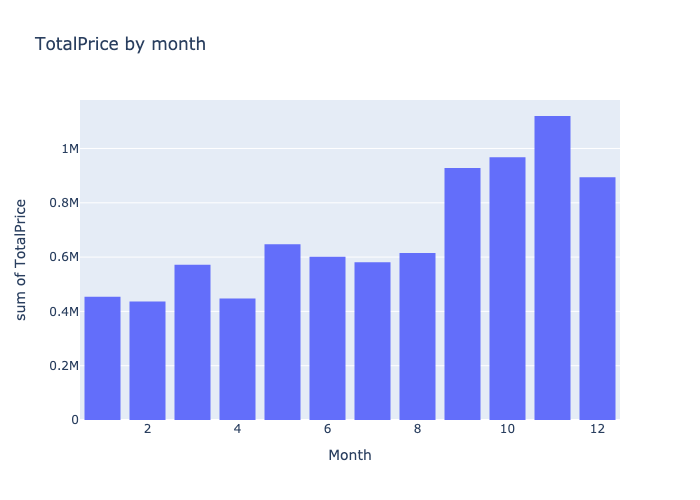

In [25]:
fig = px.histogram(
    data, 
    x='Month',
    y='TotalPrice',
    barmode='group',
    title='TotalPrice by month'    
)
fig.update_layout(bargap=0.2)
fig.show('png')

Самый прибыльный месяц - ноябрь. Такой результат объясняется довольно просто: ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, то совсем не удивительно, что мы видим максимальный рост продаж в преддверии этих праздников.

Построим визуализацию количества заказов для каждого дня недели.

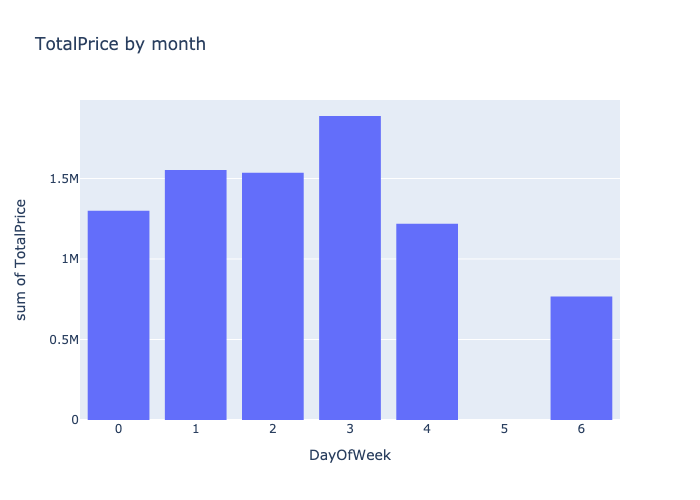

In [29]:
fig = px.histogram(
    data, 
    x='DayOfWeek',
    y='TotalPrice',
    barmode='group',
    title='TotalPrice by month'    
)
fig.update_layout(bargap=0.2)
fig.show('png')

Cогласно построенной визуализации, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.

Построим визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

In [49]:
mean_by_hour = data.groupby(['Date','Hour'])['InvoiceNo'].count().groupby('Hour').mean()
fig = px.bar(
    mean_by_hour, 
    x=mean_by_hour.index,
    y=mean_by_hour.values,
    title='Mean counts of invoices by hour',
    labels={'y':'mean counts'}    
)
fig.update_layout(bargap=0.2)
fig.show()

Больше всего заказов совершается в дневное время, в интервале от 10 до 15 часов.
C 21 часа до 6 утра заказы не поступают.

## 5. RFM-сегментация клиентов: часть 1

Воспользуемся методом RFM для анализа потребительской ценности. 

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Рассчитаем RFM-характеристики для каждого из клиентов в нашем датасете следующим образом:

* Recency для i-го клиента рассчитаем как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитаем как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитаем как общую сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

In [101]:
data_rfm = data[['CustomerID']].drop_duplicates(ignore_index=True)

data_rfm = data_rfm.merge(
    pd.DataFrame(data.groupby('CustomerID')['InvoiceDate'].max()), 
    left_on='CustomerID', 
    right_index=True
)
data_rfm['InvoiceDate'] = pd.to_datetime('2011-12-10 00:00:00') - data_rfm['InvoiceDate']
data_rfm['InvoiceDate'] = data_rfm['InvoiceDate'].dt.days

data_rfm = data_rfm.merge(
    pd.DataFrame(data.groupby('CustomerID')['InvoiceNo'].nunique()), 
    left_on='CustomerID', 
    right_index=True
)

data_rfm = data_rfm.merge(
    pd.DataFrame(data.groupby('CustomerID')['TotalPrice'].sum()), 
    left_on='CustomerID', 
    right_index=True
)

data_rfm = data_rfm.rename(
    {'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary', 'InvoiceDate': 'Recency'},
    axis=1
)
data_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,17850,372,34,5322.84
1,13047,56,9,3095.80
2,12583,2,15,6629.34
3,13748,95,5,948.25
4,15100,333,3,635.10


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

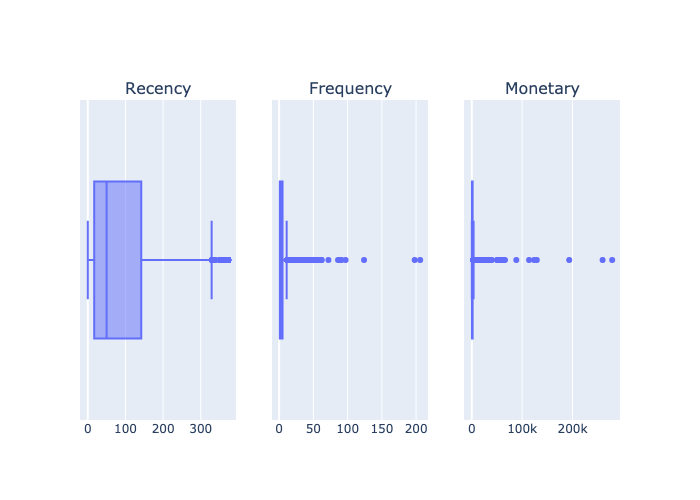

In [107]:
boxes = [px.box(data_rfm, x=column) for column in data_rfm.columns[1:]]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show('png')

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


Удалим из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

In [102]:
outliers = data_rfm[(data_rfm['Frequency'] > data_rfm['Frequency'].quantile(0.95)) |
                    (data_rfm['Monetary'] > data_rfm['Monetary'].quantile(0.95))]
rfm_cleaned = data_rfm.drop(outliers.index)
rfm_cleaned.shape

(4044, 4)

Посмотрим на коробчатые диаграммы после удаления выбросов.

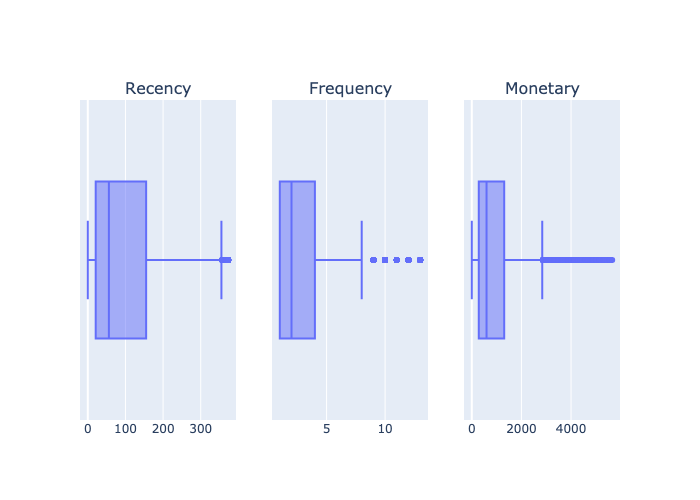

In [106]:
boxes = [px.box(rfm_cleaned, x=column) for column in rfm_cleaned.columns[1:]]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.show('png')

Попробуем оценить, как распределены наблюдения в пространстве признаков. Так как у нас всего три параметра, по которым мы хотим кластеризовать клиентов, данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


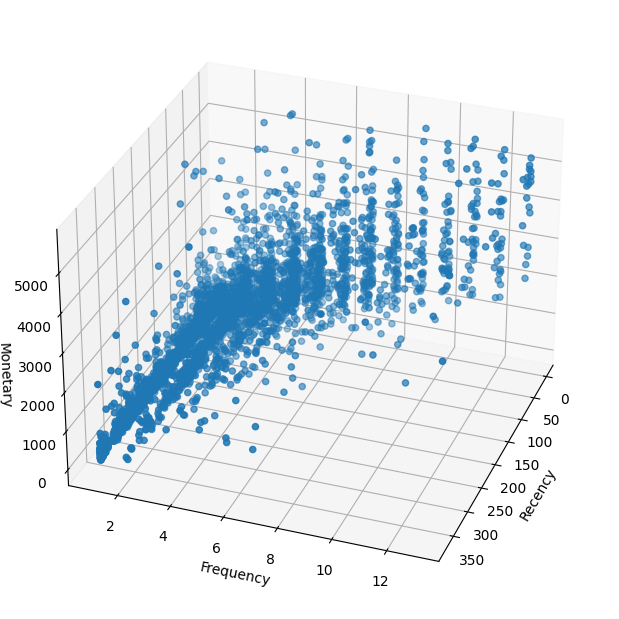

In [105]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z
ax.scatter(
    rfm_cleaned['Recency'].to_list(), 
    rfm_cleaned['Frequency'].to_list(),
    rfm_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


На графике не видно четкого деления данных на кластеры, сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

### Метод главных компонент (PCA)

Воспользуемся методом снижения размерности PCA (метод главных компонент). Для его стабильной работы данные необходимо предварительно стандартизировать/нормализовать.

In [116]:
X = rfm_cleaned[['Recency', 'Frequency', 'Monetary']]
pca_pipe = pipeline.Pipeline([
    ('s_scaler', preprocessing.StandardScaler()),
    ('pca', decomposition.PCA(n_components=2) )
])
X_transformed = pca_pipe.fit_transform(X)
pca_pipe[1].explained_variance_ratio_

array([0.67747053, 0.24012744])

In [121]:
rfm_transformed = rfm_cleaned[['CustomerID']]
rfm_transformed['axis-1'] = X_transformed.T[0]
rfm_transformed['axis-2'] = X_transformed.T[1]
rfm_transformed.head()

,CustomerID,axis-1,axis-2
1,13047,2.966840,1.072492
3,13748,0.492335,0.176863
4,15100,-1.288783,1.922532
7,17809,5.261874,1.895909
9,16098,1.666922,0.718695


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

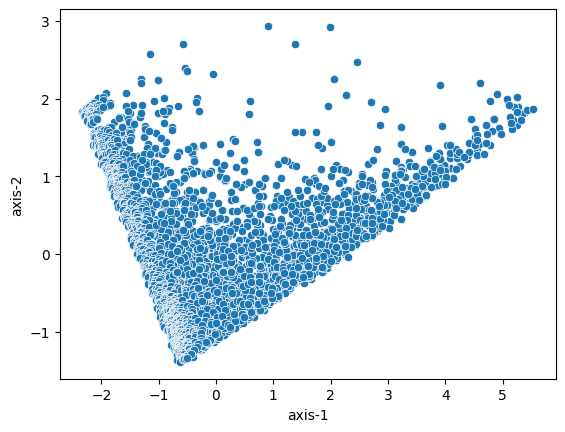

In [122]:
sns.scatterplot(data=rfm_transformed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 

### Кластеризация

Подберем оптимальное количество кластеров для метода K-Means с помощью коэффициента силуэта.

2 0.5002955980290273
3 0.5241821559595295
4 0.4975995120036197
5 0.4546966151194723
6 0.44766490770715367
7 0.42729853468336393
8 0.4217005960927487
9 0.41474375125198887
10 0.3976521898768641


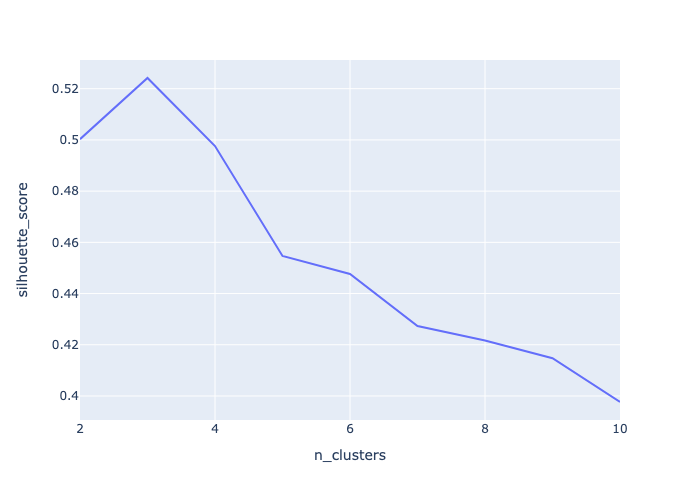

In [124]:
silhouettes = []
for n in range(2,11):
    km = cluster.KMeans(n_clusters=n, random_state=42)
    km.fit(X_transformed)
    silhouette = metrics.silhouette_score(X_transformed, km.labels_)
    silhouettes.append(silhouette)
    print (n, silhouette)
    
silhouettes = pd.DataFrame({'n_clusters': range(2,11),'silhouette_score': silhouettes})
fig = px.line(silhouettes, x='n_clusters', y='silhouette_score')
fig.show('png')

Оптимальное количество кластеров для метода k-means равно 3.


Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) также с помощью коэффициента силуэта.

2 0.34248405083913785
3 0.43546015812247607
4 0.3479518279191814
5 0.24941228123514522
6 0.2665055423624638
7 0.2519198870094913
8 0.19471644350346087
9 0.20451760750142045
10 0.15392310228205397


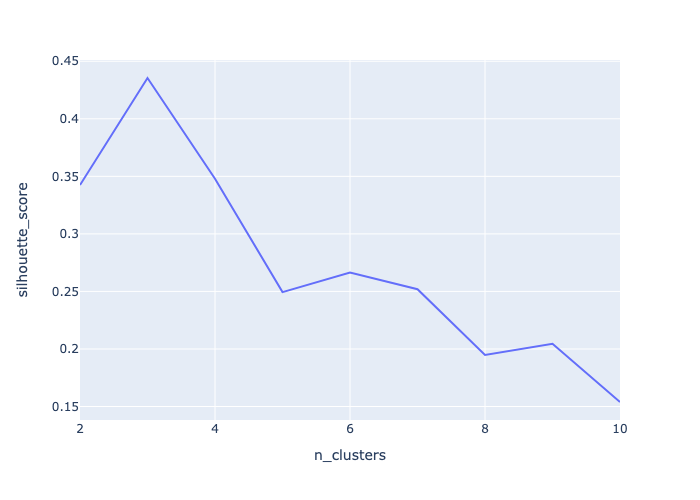

In [129]:
silhouettes = []
for n in range(2,11):
    em = mixture.GaussianMixture(n_components=n, random_state=42)
    labels = em.fit_predict(X_transformed)
    silhouette = metrics.silhouette_score(X_transformed, labels)
    silhouettes.append(silhouette)
    print (n, silhouette)
    
silhouettes = pd.DataFrame({'n_clusters': range(2,11),'silhouette_score': silhouettes})
fig = px.line(silhouettes, x='n_clusters', y='silhouette_score')
fig.show('png')

Оптимальное количество кластеров для EM-алгоритма также равно 3, но коэффициент силуата наибольший у модели K-Means. Поэтому обучим модель K-Means с оптимальным количеством кластеров.

In [130]:
km = cluster.KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(X_transformed)

Визуализируем результаты кластеризации:

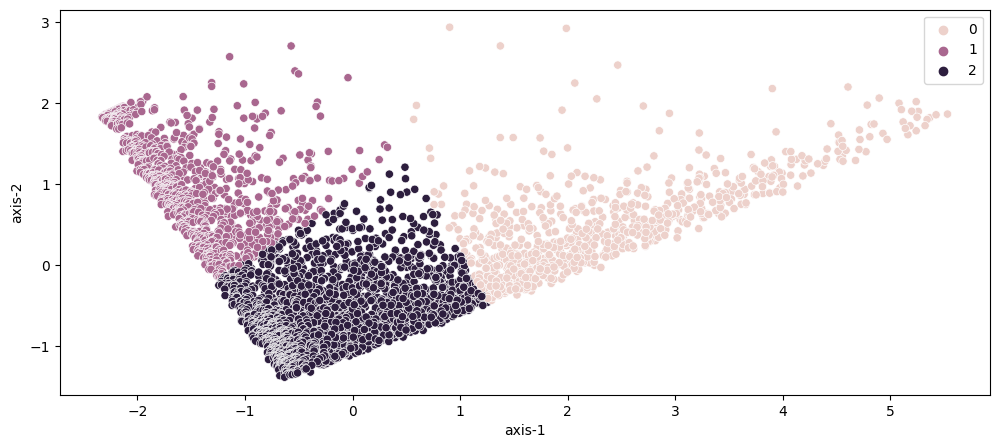

In [131]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_transformed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

In [138]:
rfm_cleaned['label'] = labels
grouped_data = rfm_cleaned.groupby('label')[['Recency', 'Frequency', 'Monetary']].mean()
grouped_data

,Recency,Frequency,Monetary
label,,,
0,31.924067,7.065637,2656.277439
1,253.283716,1.405594,386.598472
2,51.142542,2.327891,659.791037


### Полярная диаграмма
Визуализируем профиль клиентов по сегментам с помощью Radar Chart (полярная, или лепестковая, диаграмма). 

In [143]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show('png')
    

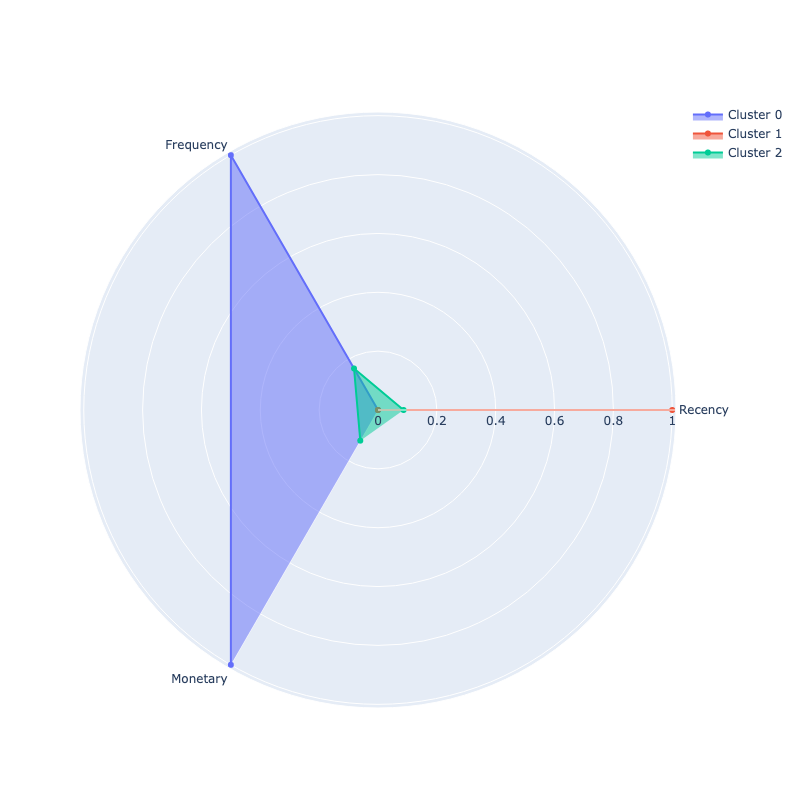

In [144]:
plot_cluster_profile(grouped_data, 3)

Описание кластеров:
* Кластер 0 - Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 1 - Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.
* Кластер 2 - Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».


## 6. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, попробуем модифицировать полученное решение.

### Снижение размерности с помощью t-SNE

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

Попробуем использовать нелинейную трансформацию с помощью алгоритма снижения размерности t-SNE.

In [140]:
X = rfm_cleaned[['Recency', 'Frequency', 'Monetary']]
tsne_pipe = pipeline.Pipeline([
    ('s_scaler', preprocessing.StandardScaler()),
    ('tsne', manifold.TSNE(n_components=2, perplexity=50, random_state=100) )
])
X_transformed = tsne_pipe.fit_transform(X)
tsne_pipe[1].kl_divergence_

0.5414092540740967

In [141]:
rfm_transformed = rfm_cleaned[['CustomerID']]
rfm_transformed['axis-1'] = X_transformed.T[0]
rfm_transformed['axis-2'] = X_transformed.T[1]
rfm_transformed.head()

,CustomerID,axis-1,axis-2
1,13047,23.305758,35.910137
3,13748,28.116943,-5.419626
4,15100,-3.905409,15.935813
7,17809,14.556798,38.145535
9,16098,35.480301,35.441540


Визуализируем пространство после декомпозиции с помощью t-SNE:


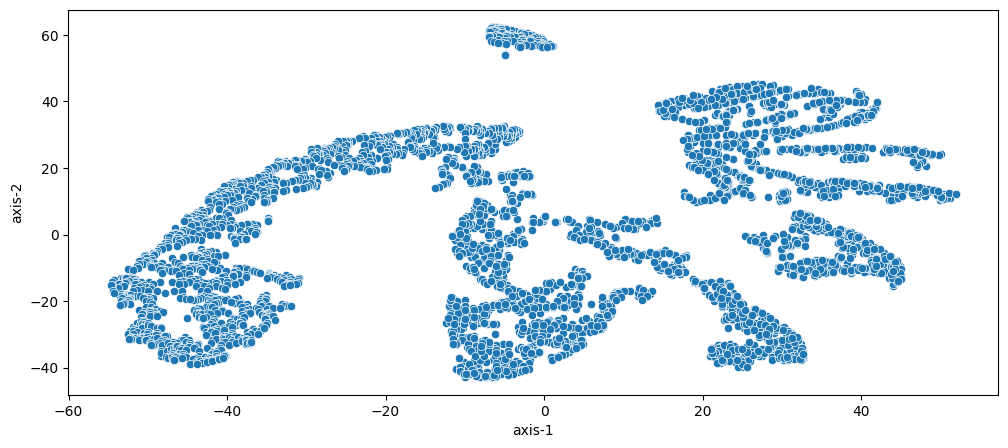

In [142]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_transformed, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Кластеризация

Попробуем воспользоваться методом k-means. 
Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта.

3 0.43279153
4 0.47816795
5 0.47846547
6 0.4801819
7 0.48383063
8 0.4811489


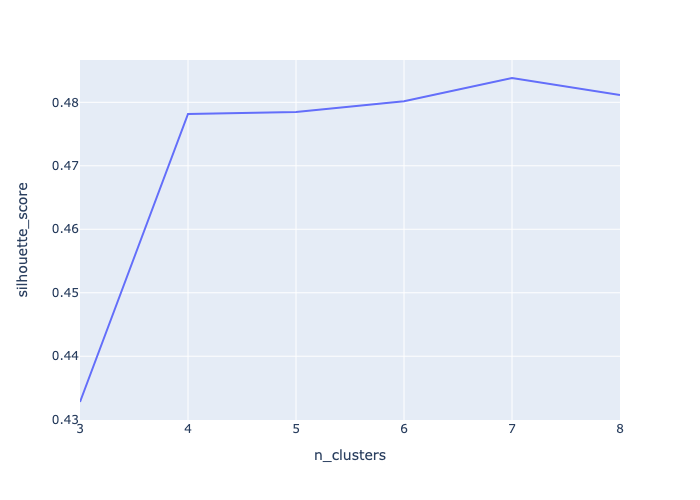

In [146]:
silhouettes = []
for n in range(3,9):
    km = cluster.KMeans(n_clusters=n, random_state=42)
    km.fit(X_transformed)
    silhouette = metrics.silhouette_score(X_transformed, km.labels_)
    silhouettes.append(silhouette)
    print (n, silhouette)
    
silhouettes = pd.DataFrame({'n_clusters': range(3,9),'silhouette_score': silhouettes})
fig = px.line(silhouettes, x='n_clusters', y='silhouette_score')
fig.show('png')

Оптимальное количество кластеров для метода k-means равно 7.


Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) также с помощью коэффициента силуэта.

3 0.40565684
4 0.46918845
5 0.38556263
6 0.35724536
7 0.4032452


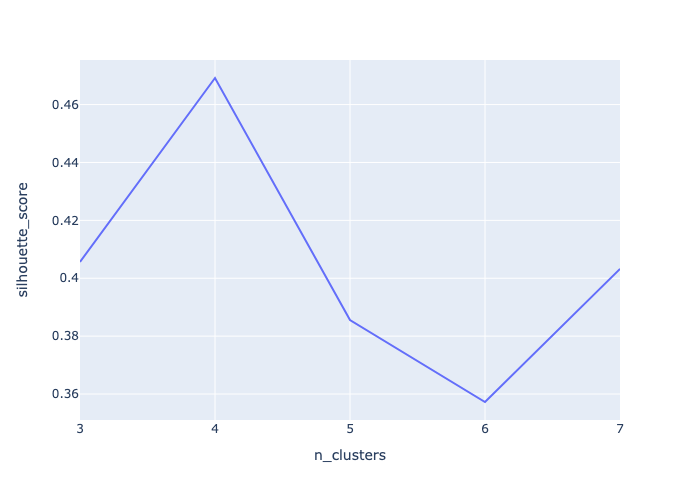

In [147]:
silhouettes = []
for n in range(3,8):
    em = mixture.GaussianMixture(n_components=n, random_state=42)
    labels = em.fit_predict(X_transformed)
    silhouette = metrics.silhouette_score(X_transformed, labels)
    silhouettes.append(silhouette)
    print (n, silhouette)
    
silhouettes = pd.DataFrame({'n_clusters': range(3,8),'silhouette_score': silhouettes})
fig = px.line(silhouettes, x='n_clusters', y='silhouette_score')
fig.show('png')

Оптимальное количество кластеров для EM-алгоритма равно 4.

Попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберем оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта.

2 0.37974402
3 0.42253074
4 0.4590107
5 0.471272
6 0.4471473
7 0.46479666
8 0.46894363


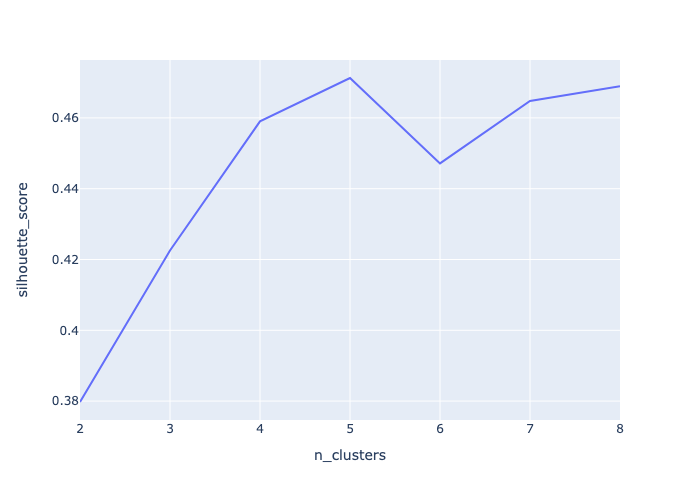

In [149]:
silhouettes = []
for n in range(2,9):
    agcl = cluster.AgglomerativeClustering(n_clusters=n)
    agcl.fit(X_transformed)
    silhouette = metrics.silhouette_score(X_transformed, agcl.labels_)
    silhouettes.append(silhouette)
    print (n, silhouette)
    
silhouettes = pd.DataFrame({'n_clusters': range(2,9),'silhouette_score': silhouettes})
fig = px.line(silhouettes, x='n_clusters', y='silhouette_score')
fig.show('png')

Оптимальное количество кластеров для аггломеративной кластеризации равно 5.

Наибольший коэффициент силуэта мы получили для модели K-Means, поэтому обучим данную модель с подобранным количеством кластеров.

In [150]:
km = cluster.KMeans(n_clusters=7, random_state=42)
labels = km.fit_predict(X_transformed)

In [151]:
rfm_cleaned['label'] = labels
rfm_cleaned['label'].value_counts()

4    914
1    683
5    656
2    543
6    446
0    405
3    397
Name: label, dtype: int64

Визуализируем результаты кластеризации:

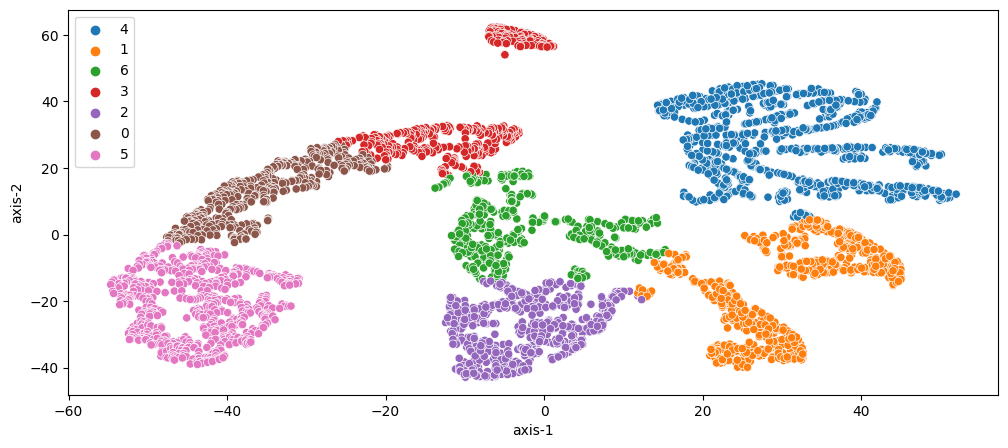

In [152]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_transformed, x='axis-1', y='axis-2', hue=km.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


In [153]:
grouped_data = rfm_cleaned.groupby('label')[['Recency', 'Frequency', 'Monetary']].mean()
grouped_data

,Recency,Frequency,Monetary
label,,,
0,181.439506,1.000000,273.465160
1,40.149341,3.450952,995.197350
2,40.022099,1.979742,613.663941
3,313.000000,1.012594,261.105315
4,32.400438,6.770241,2416.582451
5,46.329268,1.000000,321.538796
6,195.800448,2.441704,670.317960


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

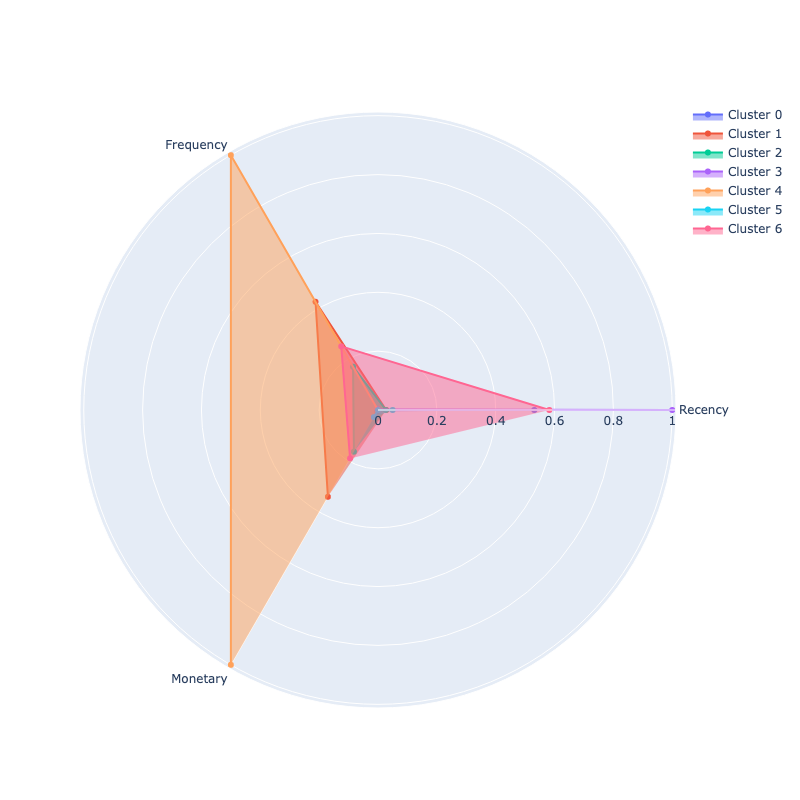

In [155]:
plot_cluster_profile(grouped_data, n_clusters=7)

Проанализируем полученные кластеры и составим для них профиль клиента:

* Кластер 4 - Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 1 - Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер 5 - Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер 6 - Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер 2 - Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер 0 - Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер 3 - Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов, обучая наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Для того, чтобы можно было определить кластер для новых объектов, сведём задачу кластеризации к задаче классификации. Теперь у нас есть истинные метки кластеров, и есть клиенты, которые описываются RFM-характеристиками. Обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

In [157]:
X = rfm_cleaned[['Recency','Frequency', 'Monetary']]
y = labels

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_test.shape

(809, 3)

Алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут.

Поэтому давайте сразу возьмём ансамблевые алгоритмы. 


### Случайный лес

In [161]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

grid_rfc = model_selection.GridSearchCV(
    ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)
grid_rfc.fit(X_train, y_train)
print('Лучшие параметры:', grid_rfc.best_params_)
print('Accuracy на тестовом наборе:', grid_rfc.score(X_test, y_test))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   0.3s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   0.3s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ......criterion=gini, max_depth=5, n_estimators=100; total time=   0.3s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.7s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.7s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.8s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.5s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.5s
[CV] END ......criterion=gini, max_depth=5, n_estimators=500; total time=   1.8s
[CV] END ......criterion=gini, max_depth=5, n_estimators=500; total time=   1.4s
[CV] END ......criterion=gin

Значение метрики accuracy достаточно высокое, но попробуем его улучшить, воспользовавшись бустингом.

### Градиентный бустинг

In [162]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}


grid_gbc = model_selection.GridSearchCV(
    ensemble.GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)
grid_gbc.fit(X_train, y_train)
print('Лучшие параметры:', grid_gbc.best_params_)
print('Accuracy на тестовом наборе:', grid_gbc.score(X_test, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Accuracy на тестовом наборе: 0.9826946847960445


Улучшить accuracy на тестовом наборе с помощью градиентного бустинга не удалось.

### CatBoost

In [171]:
cbc = CatBoostClassifier(iterations=200, verbose=0)
cbc.fit(X_train, y_train)
y_pred = cbc.predict(X_test)
print('Accuracy на тестовом наборе:', metrics.accuracy_score(y_test, y_pred))

Accuracy на тестовом наборе: 0.9876390605686032


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента определяет его сегмент.

## Результаты:

1. Мы построили две модели кластеризации клиентов на основании RFM-характеристик методом K-Means:
- первая модель (3 кластера) была обучена на сжатом пространстве признаков с помощью PCA
- вторая модель (7 кластеров) была обучена на сжатом пространстве признаков с помощью t-SNE

2. Составили профиль клиента для каждого полученного кластера.

3. Построили и обучили модель классификации для определения профиля новых клиентов. Accuracy лучшей модели классификации (CatBoost) составила 0.988